---
**The accuracy results, experimenting with various parameters and the report all are included in this notebook after the grab cut algorithm implementation.**

---

# Assignment 3 - Image Segmentation using MRFs

## GrabCut

---
**TA** : Avinash, Samartha  
**Release date**: 21/03/22  
**Submission date** : 02/04/22


---

For this assignment you will implement the GrabCut method mentioned in this [paper](https://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf). It is essentially an iterative version of GraphCut as shown in the figure below. 
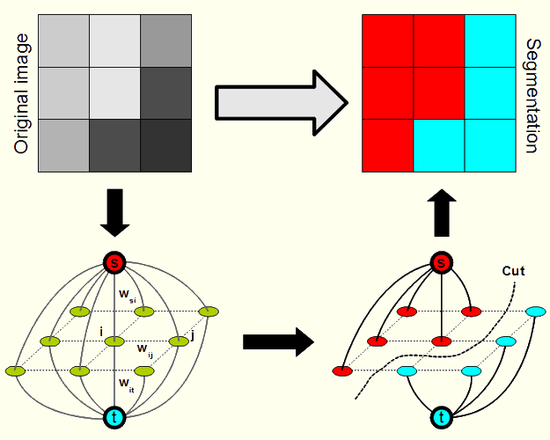

The code below takes an input image and follows these steps:
- It requires a bounding box to be drawn by the user to roughly segment out the foreground pixels
- It runs an initial min-cut optimization using the provided annotation
- The result of this optimization gives an initial segmentation 
- To further refine this segmentation, the user provides two kinds of strokes to aid the optimization
    - strokes on the background pixels
    - strokes on the foreground pixels
- The algorithm now utilizes this to refine the original segmentation

You are allowed to use standard GMM libraries for the implementation. For usage of other libraries, please contact the TAs.

You can view this [video](https://www.youtube.com/watch?v=aOqOwM-Qbtg) to get a better idea of the steps involved.

Image segmentation is one exciting application of MRFs. You can further read about other applications of MRFs for Computer Vision [here](https://cedar.buffalo.edu/~srihari/CSE574/Chap8/Ch8-PGM-Undirected/9.5-MRFinCV.pdf).

#### Useful Links
* https://courses.engr.illinois.edu/cs543/sp2011/lectures/Lecture%2012%20-%20MRFs%20and%20Graph%20Cut%20Segmentation%20-%20Vision_Spring2011.pdf

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import igraph as ig
from sklearn import mixture

In [2]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors
    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_RBUTTONDOWN:
            self.FLAGS['DRAW_RECT'] = True
            self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_RBUTTONUP:
            self.FLAGS['DRAW_RECT'] = False
            self.FLAGS['rect_over'] = True
            cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
            self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
            
            self.FLAGS['rect_or_mask'] = 0

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)
def run(filename: str, Iter = 3, connect_type = 1, n_components=5, gamma=50):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 0}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 1}

    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }

    img = cv2.imread(filename)
    img2 = img.copy()                                
    mask = np.zeros(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                     #                               1 - foreground pixels 
    output = np.zeros(img.shape, np.uint8)           # output image to be shown

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    cv2.namedWindow('Segmented output')
    
    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)

    while(1):
        
        img = EventObj.image
        mask = EventObj.mask
        FLAGS = EventObj.flags
        cv2.imshow('Segmented image', output)
        cv2.imshow('Input Image', img)
        
        k = cv2.waitKey(1)

        # key bindings
        if k == 27:
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG
        
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2], dtype = np.uint8) 
            EventObj.image = img
            EventObj.mask = mask
            output = np.zeros(img.shape, np.uint8)
        
        elif k == 13: 
            # Press carriage return to initiate segmentation
            
            #-------------------------------------------------#
            # Implement GrabCut here.                         #  
            # Function should return a mask which can be used #
            # to segment the original image as shown on L90   # 
            #-------------------------------------------------#
            (h,w) = img.shape[:2]
            
            mask = np.zeros((h,w), np.uint8)
            x,y,offset,offset2 = FLAGS['RECT']
            mask[y:y+offset2, x:x+offset] = 255
            fixed_bg = np.zeros((h,w),np.uint8)
            
            fixed_bg = cv2.bitwise_not(mask)
            Time  = time.time()           
            mask  = grabCut(img2.copy(), mask.copy(),Iter=Iter,fixed_bg=fixed_bg, connect_type=connect_type, n_components=n_components,gamma=gamma)
            Time = time.time() - Time
            EventObj.flags = FLAGS
            mask2 = np.where((mask == 255), 255, 0).astype('uint8')
            output = cv2.bitwise_and(img2, img2, mask = mask2)
            return (mask2, Time) # for automation I kept this return statement, remove it if not needed


In [3]:
def grabCut(Img, mask, Iter = 1,fixed_bg=None,fixed_fg = None,connect_type=1, n_components=5, gamma=50):
    # Step - 1 computing beta

    connected =[ [[-1,0],[0,-1]],   [[-1,0],[0,-1],[-1,-1],[-1,1]]  ] # for connected components
    Img = Img.copy().astype(np.float32)
    (h,w) = Img.shape[:2]
    # gamma = 50
    beta,count = 0,0
    
    for i in range(h):
        for j in range(w):
            for k in connected[connect_type]:
                if i + k[0] >= 0 and i + k[0] < h and j + k[1] >= 0 and j + k[1] < w:
                    beta += np.sum((Img[i,j] - Img[i+k[0],j+k[1]])**2)
                    count+=1

    beta = 1/(2*beta/count)
    def computeGMM(Img, Mask, Type, n_components=5):
        gmm = mixture.GaussianMixture(n_components=n_components)
        gmm.fit(Img[Mask == Type].reshape((-1, 3)))
        return gmm

    for iter in range(Iter):
        # Gaussian GMMs
        fg_gmm = computeGMM(Img, mask, 255,n_components=n_components)
        bg_gmm = computeGMM(Img, mask, 0,n_components=n_components)
        fg_score = fg_gmm.score_samples(Img.reshape((-1,3)))
        bg_score = bg_gmm.score_samples(Img.reshape((-1,3)))
        fg_score = -fg_score.reshape((h,w))
        bg_score = -bg_score.reshape((h,w))
        # creating the graph
        nodes,source, sink, edges, weights = h*w+2, h*w, h*w+1, [],[]
        for i in range(h):
            for j in range(w):
                if fixed_bg[i,j]>0:
                    edges.append((sink, i*w+j))
                    weights.append(10**10)
                else:
                    edges.extend([(i*w+j,source), (i*w+j, sink)])
                    weights.extend([bg_score[i,j],fg_score[i,j]])
                # edges of neighbours
                for k in connected[connect_type]:
                    if i + k[0] >= 0 and i + k[0] < h and j + k[1] >= 0 and j + k[1] < w:
                        edges.append((i*w+j, (i+k[0])*w+(j+k[1])))
                        weights.append(gamma*np.exp(-beta* (np.sum((Img[i,j] - Img[i+k[0],j+k[1]])**2))))
    
        G = ig.Graph(directed=False)
        G.add_vertices(nodes)
        G.add_edges(edges, attributes={'weight':weights})
        cut = G.mincut(source, sink, capacity='weight')
        print("cut value ", cut.value, " at iteration", iter)
        updated_fg = 0
        if source in cut.partition[0]:
            updated_fg = cut.partition[0]
        else:
            updated_fg = cut.partition[1]
        # new mask
        mask = np.zeros((h,w), np.uint8)
        
        Img_copy = np.zeros(Img.shape)
        for i in updated_fg:
            if i == source or i == sink :
                continue
            
            mask[i//w, i%w] = 255
            Img_copy[i//w, i%w] = Img[i//w, i%w]
            count+=1
      
    return mask

In [61]:

if __name__ == '__main__':
    filename = '../images/llama.jpg'
           # Path to image file
    run(filename)
    cv2.destroyAllWindows()

**The output masks of the grab cut algorithm for all the images  are stored in the results folder**

### 1- Evaluation metrics

In [7]:
import os
import time
ground_truth = sorted(os.listdir("./../ground_truth"))
test_images  = sorted(os.listdir("./../images"))
total_time = 0

for i in range(len(test_images)):  
    print("Image: ", test_images[i])
    mask, Time = run(filename="./../images/"+test_images[i])
    cv2.destroyAllWindows()
    total_time += Time
    cv2.imwrite("./../results/"+test_images[i],mask)

    # ground_truth_im = cv2.imread("./../ground_truth/"+ground_truth[i], 0)
    # accuracy  = np.sum(np.where(mask == ground_truth_im , 1, 0))/np.size(mask)
    # overlap_bg = np.sum(np.where(mask == ground_truth_im ^ 0,1,0 ))
    # Union_bg = np.sum(np.where(mask & ground_truth_im == 0, 1, 0))
    # overlap_fg = np.sum(np.where(mask == ground_truth_im ^ 255,1,0 ))
    # Union_fg = np.sum(np.where(mask | ground_truth_im == 255, 1, 0))

    
    print("Time taken", Time)
    # print("Accuracy: ", accuracy)
    # print("Jaccard similarity ", (overlap_fg/Union_fg + overlap_bg/Union_bg)/2)
    # print("Dice similarity ", ( (2*overlap_fg + 2*overlap_bg)/(2*(mask.shape[0]*mask.shape[1])*2)))
    # print("\n")



Image:  banana1.jpg
Draw the rectangle first.
Draw the rectangle first.
Draw the rectangle first.
Time taken 203.585280418396
Image:  banana2.jpg
Draw the rectangle first.
Draw the rectangle first.
Draw the rectangle first.
Time taken 174.7626051902771
Image:  banana3.jpg
Time taken 148.8161883354187
Image:  book.jpg
Time taken 174.13097167015076
Image:  bool.jpg
Time taken 94.70087695121765
Image:  bush.jpg
Time taken 114.70276546478271
Image:  ceramic.jpg
Time taken 105.88416910171509
Image:  cross.jpg
Time taken 117.62287998199463
Image:  doll.jpg
Time taken 119.07059669494629
Image:  elefant.jpg
Time taken 130.12101578712463
Image:  flower.jpg
Time taken 80.41238737106323
Image:  fullmoon.jpg
Time taken 35.31244158744812
Image:  grave.jpg
Time taken 69.81033492088318
Image:  llama.jpg
Time taken 86.41161918640137
Image:  memorial.jpg
Time taken 105.18309879302979
Image:  music.jpg
Time taken 136.32353973388672
Image:  person1.jpg
Time taken 95.813955783844
Image:  person2.jpg
Time 

**All the output masks are stored in the results folder**

#### Average time

In [9]:
print("For 3 iterations, the Average time taken for the grabcut algorithm to run is -", total_time/len(test_images))

For 3 iterations, the Average time taken for the grabcut algorithm to run is - 107.00091772079467


### Accuracy, Jaccard similarity, Dice similarity coefficient

In [16]:
ground_truth = sorted(os.listdir("./../ground_truth"))
test_images  = sorted(os.listdir("./../results"))
for i in range(len(test_images)):  
    print("Image: ", test_images[i])
    truth = cv2.imread("./../ground_truth/"+ground_truth[i],0)
    grab_cut = cv2.imread("./../results/"+test_images[i],0)

    accuracy  = np.sum(np.where(grab_cut == truth , 1, 0))/np.size(grab_cut)
    overlap_bg = np.sum(np.where(grab_cut == truth ^ 0,1,0 ))
    Union_bg = np.sum(np.where(grab_cut & truth == 0, 1, 0))
    overlap_fg = np.sum(np.where(grab_cut == truth ^ 255,1,0 ))
    Union_fg = np.sum(np.where(grab_cut | truth == 255, 1, 0))
    intersection = np.sum(grab_cut[truth==255]==255)
    print("Accuracy: ", accuracy)
    print("Jaccard similarity ", (overlap_fg/Union_fg + overlap_bg/Union_bg)/2)
    print("Dice similarity ",(2*intersection)/(np.sum(truth[truth==255]==255)+ np.sum(grab_cut[grab_cut==255]==255)))
    print("\n\n")

Image:  banana1.jpg
Accuracy:  0.68787109375
Jaccard similarity  0.730029672409705
Dice similarity  0.6233935411908862



Image:  banana2.jpg
Accuracy:  0.973935546875
Jaccard similarity  0.6528885603001087
Dice similarity  0.9595595026642983



Image:  banana3.jpg
Accuracy:  0.88787109375
Jaccard similarity  0.7247548453981588
Dice similarity  0.8186161968137797



Image:  book.jpg
Accuracy:  0.955771484375
Jaccard similarity  0.794595959760663
Dice similarity  0.9565802587976727



Image:  bool.jpg
Accuracy:  0.7904829059829059
Jaccard similarity  0.7533593309402247
Dice similarity  0.5636408206365968



Image:  bush.jpg
Accuracy:  0.9675592592592592
Jaccard similarity  0.6186018669682072
Dice similarity  0.9248905277713759



Image:  ceramic.jpg
Accuracy:  0.9523177083333333
Jaccard similarity  0.7297904110197548
Dice similarity  0.9411413359696412



Image:  cross.jpg
Accuracy:  0.9043444444444444
Jaccard similarity  0.7439658439045862
Dice similarity  0.8631319638772371



Image: 

#### From the similarity scores, these are few good and bad outputs of grab cut algorithm

**some best outputs**

                            

Full moon  - Accuracy: 0.9905817711700065, Time(s) : 35.31244158744812

flower - Accuracy: 0.9845333333333334, Time(s) : 80.41238737106323

person2 - Accuracy:     0.985362962962963, Time(s) : 91.93188714981079

person3 - Accuracy:     0.982937037037037, Time(s) : 81.40443229675293


**some bad outputs**

banana1 - Accuracy:     0.68787109375 , Time(s) :203.585280418396

banana3 - Accuracy:     0.88787109375, Time(s) : 203.585280418396



Good results


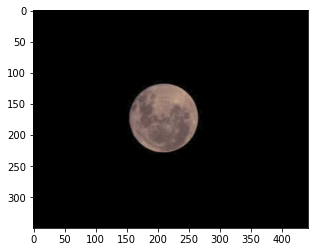

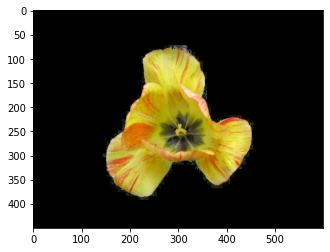

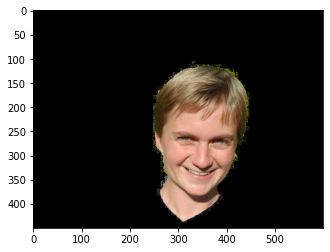

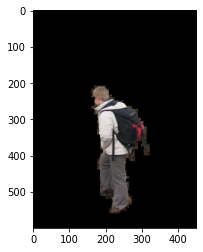

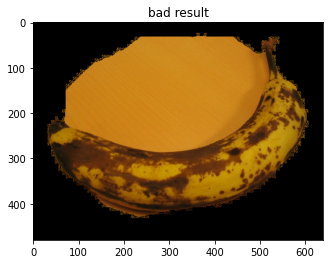

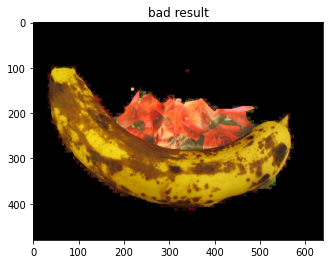

In [21]:
print("Good results")
img = cv2.imread("./../images/fullmoon.jpg")
mask = cv2.imread("./../results/fullmoon.jpg",0)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.bitwise_and(img,img, mask= mask)
plt.figure()
plt.imshow(img)

img = cv2.imread("./../images/flower.jpg")
mask = cv2.imread("./../results/flower.jpg",0)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.bitwise_and(img,img, mask= mask)
plt.figure()
plt.imshow(img)

img = cv2.imread("./../images/person2.jpg")
mask = cv2.imread("./../results/person2.jpg",0)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.bitwise_and(img,img, mask= mask)
plt.figure()
plt.imshow(img)

img = cv2.imread("./../images/person3.jpg")
mask = cv2.imread("./../results/person3.jpg",0)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.bitwise_and(img,img, mask= mask)
plt.figure()
plt.imshow(img)



img = cv2.imread("./../images/banana1.jpg")
mask = cv2.imread("./../results/banana1.jpg",0)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.bitwise_and(img,img, mask= mask)
plt.figure()
plt.imshow(img)
plt.title("bad result")
img = cv2.imread("./../images/banana3.jpg")
mask = cv2.imread("./../results/banana3.jpg",0)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.bitwise_and(img,img, mask= mask)
plt.figure()
plt.title("bad result")
plt.imshow(img)



## Experiments

#### 1 - The number of iterations of GMM updating and energy minimization

Iterations 1
cut value  2434262.9702194296  at iteration 0
Iterations =  4
cut value  2314293.1558154025  at iteration 0
cut value  2215259.3647634005  at iteration 1
cut value  2211069.9814446433  at iteration 2
cut value  2209347.5354035846  at iteration 3


Text(0.5, 1.0, 'Iterations = 4')

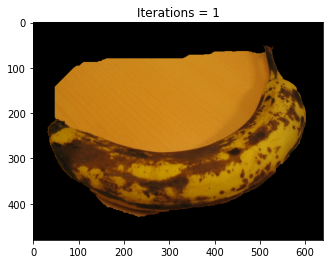

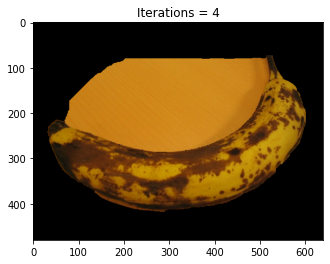

In [61]:
iter = 1
print("Iterations", iter)
mask,_ = run("./../images/banana1.jpg",iter)
img = cv2.imread("./../images/banana1.jpg")
img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
img = cv2.bitwise_and(img,img, mask= mask)
plt.title("Iterations = "+str(iter))
plt.imshow(img)
iter = 4
print("Iterations = ",iter)
mask,_ = run("./../images/banana1.jpg",iter)
img = cv2.imread("./../images/banana1.jpg")

img = cv2.bitwise_and(img,img, mask= mask)
img = cv2.bitwise_and(img,img, mask= mask)

plt.figure()
plt.imshow(img)
plt.title("Iterations = "+str(iter))

As the number of iterations in the grab cut algorithm increases, the grab cut algorithm tries to minimises the energy, can be obeserved by seeing the output of the above cell and keeps on decreases until it converges. It means that as the number of iterations increases, the algorithm tries to improve the quality of segmenting the foreground region, and the same can be observed from the above results. We can see that background region marking as foreground is slightly reduced when the iterations are increased, and also the energy is minimised at every iteration. But the time complexity increases when we increase the number of iterations. 

#### 2 - Different ways to represent probabilities other than GMMs. 4-neighborhood or 8-neighborhood in your pairwise term. 

cut value  849069.8833122276  at iteration 0
cut value  817078.4376672946  at iteration 1
cut value  816641.7975561488  at iteration 2
cut value  923805.9786730857  at iteration 0
cut value  885935.1024540036  at iteration 1
cut value  885957.8806120167  at iteration 2


Text(0.5, 1.0, '8 - neighborhood')

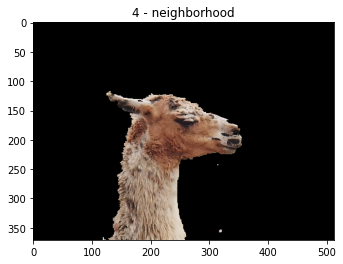

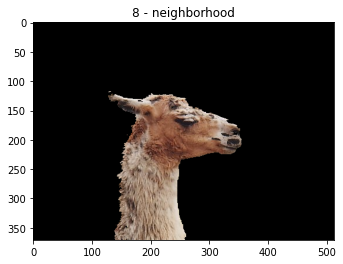

In [36]:
Connect_type = 0 # indicates 4-neightborhood
mask,_ = run("./../images/llama.jpg",connect_type = Connect_type)
img = cv2.imread("./../images/llama.jpg")
img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
img = cv2.bitwise_and(img,img, mask= mask)
plt.title("4 - neighborhood")
plt.imshow(img)

Connect_type = 1

mask,_ = run("./../images/llama.jpg",connect_type=Connect_type)
img = cv2.bitwise_and(img,img, mask= mask)

plt.figure()
plt.imshow(img)
plt.title("8 - neighborhood")

We can notice that both 4 -neighborhood and 8 - neighborhood almost seperated the foreground and background segments, but if we observe clearly, 4-neighborhood marked some background also as foreground but 8-neighborhood doesn't, also 4-neighborhood has sharper transistions at the edges compared to 8 - neighborhood. This is because as the number of connected edges decreases, the grabcut algorithm gives more importance to the unary term which means to color and so the background that is similar to foreground color can be considered as foreground. 

#### 3 - The number of mixture components in your GMM

Draw the rectangle first.
cut value  1654176.2007647394  at iteration 0
cut value  1424950.9292972386  at iteration 0


Text(0.5, 1.0, 'No. of mixture components in GMM =10')

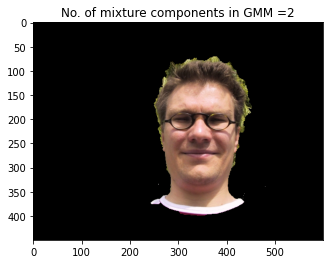

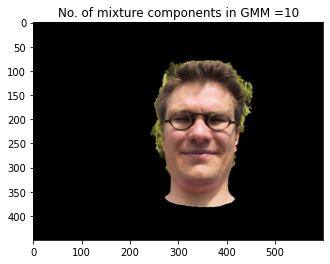

In [58]:
n_components = 2 
mask,_ = run("./../images/person1.jpg",n_components = n_components,Iter=1)
img = cv2.imread("./../images/person1.jpg")
img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
img = cv2.bitwise_and(img,img, mask= mask)
plt.title("No. of mixture components in GMM ="+str(n_components))
plt.imshow(img)

n_components = 10

mask,_ = run("./../images/person1.jpg",n_components = n_components,Iter=1)
img = cv2.imread("./../images/person1.jpg")
img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
img = cv2.bitwise_and(img,img, mask= mask)

plt.figure()
plt.imshow(img)
plt.title("No. of mixture components in GMM ="+str(n_components))

The number of mixtue components helps in modelling the foreground and background using different combinations of gaussian functions. When the mixture components are not sufficient enough, then it cannot model the foreground and background perfectly, just like as in the above figure for GMM =2, here we can see that the white  color of the T-shirt is marked as foreground, but when we increase the number of mixture components, we can see that it got removed. Similar things assuming foreground as background may be possible if there are lot of variations in the foreground. So, taking more number of mixture components in GMM is better.

#### 4 - The choice of gamma

cut value  801398.0165818013  at iteration 0
cut value  808087.0875677713  at iteration 0


Text(0.5, 1.0, 'Gamma = 50')

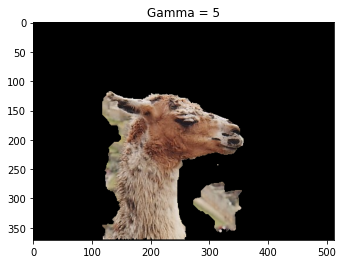

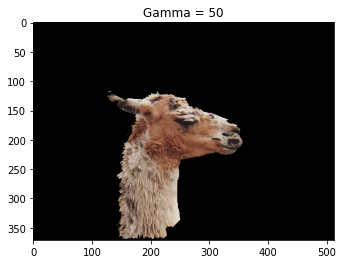

In [51]:
gamma = 5
mask,_ = run("./../images/llama.jpg",gamma = gamma,Iter=1)
img = cv2.imread("./../images/llama.jpg")
img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
img1 = cv2.bitwise_and(img,img, mask= mask)
plt.title("Gamma = "+str(gamma))
plt.imshow(img1)

gamma = 50

mask,_ = run("./../images/llama.jpg",gamma=gamma,Iter=1)
img = cv2.bitwise_and(img,img, mask= mask)

plt.figure()
plt.imshow(img)
plt.title("Gamma = "+str(gamma))

To some extent, gamma term in the grabcut algorithm mainly determines the degree of smoothnes. From the above comparison for gamma = 5, gamma = 50, we can observe that when gamma = 5, some part of the background which has similar intensities with foreground also marked as foreground. But it is discarded when gamma = 50. When we decrease the value of it, the adjacent edge weights also decreases, so we are giving increasing the importance of intensities values because of that background having similar intensities are marked as foreground.

#### 5 - Initial bounding box - Loosing bounding box vs Tight bounding box

cut value  1699601.7864577882  at iteration 0
cut value  1634377.5044042068  at iteration 1
cut value  1633838.5302183523  at iteration 2
cut value  731828.9372899143  at iteration 0
cut value  706683.8209783091  at iteration 1
cut value  706928.7251693363  at iteration 2


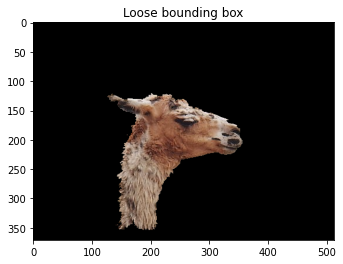

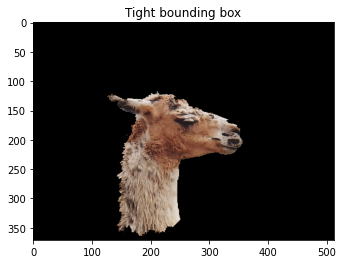

In [59]:

mask,_ = run("./../images/llama.jpg")
img = cv2.imread("./../images/llama.jpg")
img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
img1 = cv2.bitwise_and(img,img, mask= mask)
plt.title("Loose bounding box")
plt.imshow(img1)

mask, _= run("./../images/llama.jpg")
img = cv2.bitwise_and(img,img, mask= mask)
plt.figure()
plt.title("Tight bounding box")
plt.imshow(img)

The grab cut algorithm will not perform well when the bounding box is loose, we can see it from above also, some of the parts of foreground are missing. When the bounding box is loose, the number of background pixels are less and also there may more variations in the foreground and hence it cannot clearly predict the foreground pixels.